# Train on differnet beta values and check if there is a phase transition.

In [1]:
import sys
import os
sys.path.append('Jerome_scripts_Original/PGM/')
sys.path.append('selfPackages/')
sys.path.append('Jerome_scripts_Original/')

import numpy as np
import scipy as sc
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

try:
    import rbm
    import bm
except:
    print 'Compiling cy_utilities first'
    curr_dir = os.getcwd()
    os.chdir('PGM/')
    !python setup.py build_ext --inplace
    print 'Compilation done'
    os.chdir(curr_dir)
    
import pickle
from ising import IsingModel
import estimate_correlations_ising
from sklearn.utils import shuffle
import inlineMovies

In [113]:
#import dill
#dill.dump_session('./data_bruckner/data/notebookData/13_beta_vs_PeakWidth_PT.db')

In [ ]:
#import dill
#dill.load_session('./data_bruckner/data/notebookData/13_beta_vs_PeakWidth_PT.db')

In [4]:
def beta_from_corrLength(corrLen):
    beta = np.tan((np.exp(-1./corrLen)))
    return beta

In [5]:
#corrLengths = np.array([0.1,0.5,1.,5,10.,20.,50,100])
#corrLengths = np.linspace(0.01,20,10)
#beta = np.linspace(0.00001,1.2,10)
beta = np.array([10**-5,10**-4,10**-3,10**-2,10**-1,0.25,0.5,0.75,10**0,1.1])
print beta
print corrLengths

[  1.00000000e-05   1.00000000e-04   1.00000000e-03   1.00000000e-02
   1.00000000e-01   2.50000000e-01   5.00000000e-01   7.50000000e-01
   1.00000000e+00   1.10000000e+00]


NameError: name 'corrLengths' is not defined

In [6]:
#Defining Parameters
Num_configs = 10000
#Nstep       = beta*1000/1.5 #The number of Markov Chain steps for no correlation in the input data. This number was dec
                            # by checking the numebr of steps required for highest beta value which is 1000, which we scale further down.
N = np.zeros(len(beta)) + 100
Nstep = np.zeros(len(beta)) + 200
print N

#Change the array type to int array from float array
N = N.astype(int)
Nstep = Nstep.astype(int)

[ 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.]


In [ ]:
%%capture captX

Xdata_big    = []
Xresults_big = []

XBM      = []
Xdata    = []
Xresults = []
XRBM     = []

Num_reps = 10

for j in range(Num_reps):
    
    Xdata_big.append(Xdata)
    Xresults_big.append(Xresults)
    
    XBM      = []
    Xdata    = []
    Xresults = []
    XRBM     = []
    
    for i in np.arange(len(beta)):
        #Generate spins using Gibbs Sampling MCMC
        XBM.append(bm.BM(N=N[i],nature='Spin'))

        #Define Couplings
        XBM[i].layer.couplings =  beta[i]*(np.eye(N=N[i],k=1) + np.eye(N=N[i],k=-1) )
        XBM[i].layer.couplings[0,-1] += beta[i]
        XBM[i].layer.couplings[-1,0] += beta[i]

        #Generating the ising model data
        Xdata.append(XBM[i].gen_data(Nchains=1,Nthermalize=0,Lchains=Num_configs,Nstep=Nstep[i])) # N steps.

        #Train the model
        XRBM.append(rbm.RBM(visible = 'Spin', n_v=N[i], n_h = 1, hidden = 'Spin',zero_field = True))
        Xresults.append(XRBM[i].fit(Xdata[i],n_iter=250,verbose=0,learning_rate = 0.001,record=['W'],record_interval=100,batch_size=10,N_MC= 20, lr_decay=False,batch_norm=False))

In [92]:
#del Xdata_big[0]
#del Xresults_big[0]
Xdata_big.append(Xdata)
Xresults_big.append(Xresults)

In [ ]:
# Top Eignvectors of the C_ij matrix:
def topEV(data):
    #Find the covariance matrix:
    covMAT = np.cov(data)
    Eval,Evec = np.linalg.eig(covMAT)
    return Evec(:,argmax(Eval))

### Calculate Sum of Weights, if that is the order parameter?

In [75]:
weights_sum = np.zeros([Num_reps,len(beta)])
for j in range(Num_reps-1):    
    for i in np.arange(len(beta)):
        weights_sum[j,i] = np.sum(np.array(Xresults_big[j][i]['W'])[-1,0,:])

Text(0.5,1,u'"Sum of Weights" order parameter with N/S = 0.01')

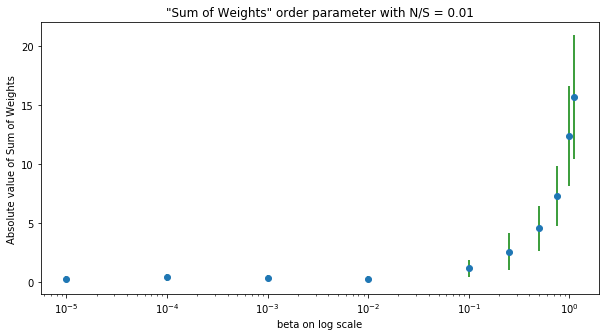

In [100]:
plt.figure(figsize=(10,5))
plt.errorbar((beta),(np.mean(abs(weights_sum),axis=0)),yerr=np.std(abs(weights_sum),axis=0),xlolims=0,fmt='o',ecolor='g')
plt.xscale('log')
plt.xlabel('beta on log scale')
plt.ylabel('Absolute value of Sum of Weights')
plt.title('"Sum of Weights" order parameter with N/S = 0.01')

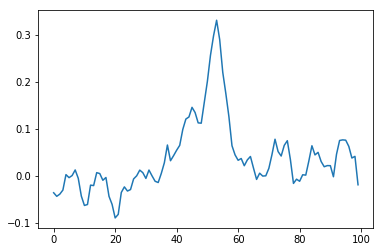

In [65]:
plt.plot(np.array(Xresults_big[1][5]['W'])[-1,0,:])

In [51]:
print beta

[  1.00000000e-05   1.00000000e-04   1.00000000e-03   1.00000000e-02
   1.00000000e-01   2.50000000e-01   5.00000000e-01   7.50000000e-01
   1.00000000e+00   1.10000000e+00]


## Calculate Overlap(dot product) of the weights with the top Eigenvector - is that the order parameter?

In [94]:
# Top Eignvectors of the C_ij matrix:
def topEV(data,method='Covariance'):
    if method is 'Covariance':
        #Find the covariance matrix:
        covMAT = np.cov(data)
    elif method is 'Correlation':
        covMAT = np.corrcoef(data)
    Eval,Evec = np.linalg.eig(covMAT)
    return Evec[:,np.argmax(Eval)],np.max(Eval)

In [96]:
weights_overlap = np.zeros([Num_reps,len(beta)])
mat_topEval_corr = np.zeros([Num_reps,len(beta)])
mat_topEV_corr = np.zeros([Num_reps,len(beta),N[0]])

for j in range(Num_reps):    
    for i in np.arange(len(beta)):
        mat_topEV_corr[j,i,:],mat_topEval_corr[j,i] = topEV(Xdata_big[j][i].T,method='Correlation')
        weights_overlap[j,i] = np.dot(mat_topEV_corr[j,i,:],(np.array(Xresults_big[j][i]['W'])[-1,0,:]))

Text(0.5,1,u'"Overlap of Top Eignevector with Weights" order parameter with N/S = 0.01')

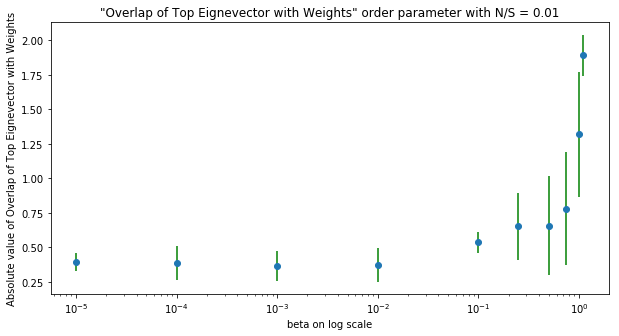

In [101]:
plt.figure(figsize=(10,5))
plt.errorbar((beta),(np.mean(abs(weights_overlap),axis=0)),yerr=np.std(abs(weights_overlap),axis=0),xlolims=0,fmt='o',ecolor='g')
plt.xscale('log')
plt.xlabel('beta on log scale')
plt.ylabel('Absolute value of Overlap of Top Eignevector with Weights')
plt.title('"Overlap of Top Eignevector with Weights" order parameter with N/S = 0.01')

## With 2 hidden Units in the RBM - does it change the transition point, since there are more parameters (weights) to be trained?

In [ ]:
%%capture captX2

Xdata_big2    = []
Xresults_big2 = []

XBM2      = []
Xdata2    = []
Xresults2 = []
XRBM2     = []

Num_reps = 10

for j in range(Num_reps):
       
    for i in np.arange(len(beta)):
        #Generate spins using Gibbs Sampling MCMC
        XBM2.append(bm.BM(N=N[i],nature='Spin'))

        #Define Couplings
        XBM2[i].layer.couplings =  beta[i]*(np.eye(N=N[i],k=1) + np.eye(N=N[i],k=-1) )
        XBM2[i].layer.couplings[0,-1] += beta[i]
        XBM2[i].layer.couplings[-1,0] += beta[i]

        #Generating the ising model data
        Xdata2.append(XBM2[i].gen_data(Nchains=1,Nthermalize=0,Lchains=Num_configs,Nstep=Nstep[i])) # N steps.

        #Train the model
        XRBM2.append(rbm.RBM(visible = 'Spin', n_v=N[i], n_h = 2, hidden = 'Spin',zero_field = True))
        Xresults2.append(XRBM2[i].fit(Xdata2[i],n_iter=250,verbose=0,learning_rate = 0.001,record=['W'],record_interval=100,batch_size=10,N_MC= 20, lr_decay=False,batch_norm=False))
        
    Xdata_big2.append(Xdata2)
    Xresults_big2.append(Xresults2)
    
    XBM2      = []
    Xdata2    = []
    Xresults2 = []
    XRBM2     = []

In [ ]:
weights_sum2 = np.zeros([Num_reps,len(beta),2])
for j in range(Num_reps):    
    for i in np.arange(len(beta)):
        weights_sum2[j,i,0] = np.sum(np.array(Xresults_big2[j][i]['W'])[-1,0,:])
        weights_sum2[j,i,1] = np.sum(np.array(Xresults_big2[j][i]['W'])[-1,1,:])

Text(0.5,1,u'"Sum of Weights" order parameter with N/S = 0.01')

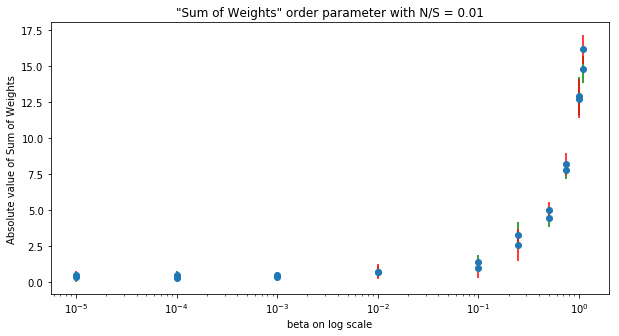

In [110]:
plt.figure(figsize=(10,5))
plt.errorbar((beta),(np.mean(abs(weights_sum2[:,:,0]),axis=0)),yerr=np.std(abs(weights_sum2[:,:,0]),axis=0),xlolims=0,fmt='o',ecolor='g')
plt.errorbar((beta),(np.mean(abs(weights_sum2[:,:,1]),axis=0)),yerr=np.std(abs(weights_sum2[:,:,1]),axis=0),xlolims=0,fmt='o',ecolor='r')
plt.xscale('log')
plt.xlabel('beta on log scale')
plt.ylabel('Absolute value of Sum of Weights')
plt.title('"Sum of Weights" order parameter with N/S = 0.01')

In [111]:
weights_overlap2 = np.zeros([Num_reps,len(beta),2])
mat_topEval_corr2 = np.zeros([Num_reps,len(beta)])
mat_topEV_corr2 = np.zeros([Num_reps,len(beta),N[0]])

for j in range(Num_reps):    
    for i in np.arange(len(beta)):
        mat_topEV_corr2[j,i,:],mat_topEval_corr2[j,i] = topEV(Xdata_big2[j][i].T,method='Correlation')
        weights_overlap2[j,i,0] = np.dot(mat_topEV_corr2[j,i,:],(np.array(Xresults_big2[j][i]['W'])[-1,0,:]))
        weights_overlap2[j,i,1] = np.dot(mat_topEV_corr2[j,i,:],(np.array(Xresults_big2[j][i]['W'])[-1,1,:]))

Text(0.5,1,u'"Overlap of Top Eignevector with Weights" order parameter with N/S = 0.01')

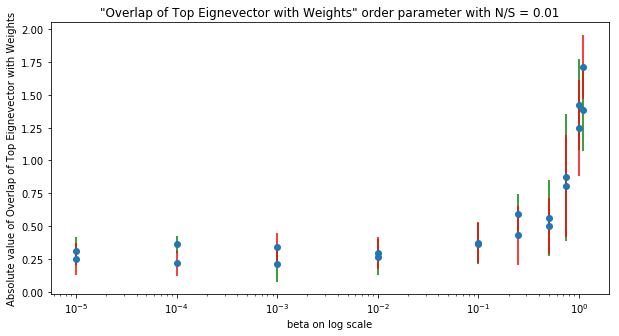

In [112]:
plt.figure(figsize=(10,5))
plt.errorbar((beta),(np.mean(abs(weights_overlap2[:,:,0]),axis=0)),yerr=np.std(abs(weights_overlap2[:,:,0]),axis=0),xlolims=0,fmt='o',ecolor='g')
plt.errorbar((beta),(np.mean(abs(weights_overlap2[:,:,1]),axis=0)),yerr=np.std(abs(weights_overlap2[:,:,1]),axis=0),xlolims=0,fmt='o',ecolor='r')
plt.xscale('log')
plt.xlabel('beta on log scale')
plt.ylabel('Absolute value of Overlap of Top Eignevector with Weights')
plt.title('"Overlap of Top Eignevector with Weights" order parameter with N/S = 0.01')

## Does the Threshold shift with l1 or l2 regularization?

In [4]:
#corrLengths = np.array([0.1,0.5,1.,5,10.,20.,50,100])
#corrLengths = np.linspace(0.01,20,10)
#beta = np.linspace(0.00001,1.2,10)
beta = np.array([10**-2,0.075,0.05,10**-1,0.15,0.2,0.25,0.5,0.75,10**0])
print beta
#print corrLengths

[ 0.01   0.075  0.05   0.1    0.15   0.2    0.25   0.5    0.75   1.   ]


In [20]:
%%capture captX3

Xdata_big3    = []
Xresults_big3 = []

XBM3      = []
Xdata3    = []
Xresults3 = []
XRBM3     = []

Num_reps = 1

for j in range(Num_reps):
       
    for i in np.arange(len(beta)):
        #Generate spins using Gibbs Sampling MCMC
        XBM3.append(bm.BM(N=N[i],nature='Spin'))

        #Define Couplings
        XBM3[i].layer.couplings =  beta[i]*(np.eye(N=N[i],k=1) + np.eye(N=N[i],k=-1) )
        XBM3[i].layer.couplings[0,-1] += beta[i]
        XBM3[i].layer.couplings[-1,0] += beta[i]

        #Generating the ising model data] 
        Xdata3.append(XBM3[i].gen_data(Nchains=1,Nthermalize=0,Lchains=Num_configs,Nstep=Nstep[i])) # N steps.

        #Train the model
        XRBM3.append(rbm.RBM(visible = 'Spin', n_v=N[i], n_h = 1, hidden = 'Spin',zero_field = True))
        Xresults3.append(XRBM3[i].fit(Xdata3[i],n_iter=250,verbose=0,learning_rate = 0.001,record=['W'],l2 = 0.05 \
                                      ,record_interval=100,batch_size=10,N_MC= 20, lr_decay=False,batch_norm=False))
        
    Xdata_big3.append(Xdata3)
    Xresults_big3.append(Xresults3)
    
    XBM3      = []
    Xdata3    = []
    Xresults3 = []
    XRBM3     = []

In [22]:
weights_sum3 = np.zeros([Num_reps,len(beta),2])
for j in range(Num_reps):    
    for i in np.arange(len(beta)):
        weights_sum3[j,i,0] = np.sum(np.array(Xresults_big3[j][i]['W'])[-1,0,:])
        #weights_sum3[j,i,1] = np.sum(np.array(Xresults_big3[j][i]['W'])[-1,1,:])

Text(0.5,1,u'"Sum of Weights" order parameter with N/S = 0.01')

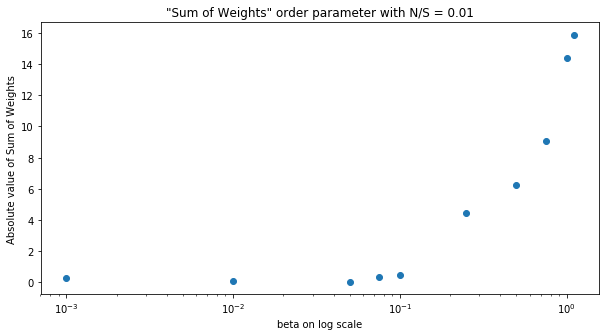

In [25]:
plt.figure(figsize=(10,5))
plt.errorbar((beta),(np.mean(abs(weights_sum3[:,:,0]),axis=0)),yerr=np.std(abs(weights_sum3[:,:,0]),axis=0),xlolims=0,fmt='o',ecolor='g')
#plt.errorbar((beta),(np.mean(abs(weights_sum3[:,:,1]),axis=0)),yerr=np.std(abs(weights_sum3[:,:,1]),axis=0),xlolims=0,fmt='o',ecolor='r')
plt.xscale('log')
plt.xlabel('beta on log scale')
plt.ylabel('Absolute value of Sum of Weights')
plt.title('"Sum of Weights" order parameter with N/S = 0.01')

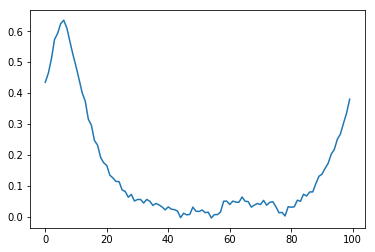

In [28]:
plt.plot(np.array(Xresults_big3[0][8]['W'])[-1,0])

## With multiple hidden units:

In [ ]:
%%capture captX4

Xdata_big4    = []
Xresults_big4 = []

XBM4      = []
Xdata4    = []
Xresults4 = []
XRBM4     = []

Num_reps = 1

for j in range(Num_reps):
       
    for i in np.arange(len(beta)):
        #Generate spins using Gibbs Sampling MCMC
        XBM4.append(bm.BM(N=N[i],nature='Spin'))

        #Define Couplings
        XBM4[i].layer.couplings =  beta[i]*(np.eye(N=N[i],k=1) + np.eye(N=N[i],k=-1) )
        XBM4[i].layer.couplings[0,-1] += beta[i]
        XBM4[i].layer.couplings[-1,0] += beta[i]

        #Generating the ising model data] 
        Xdata4.append(XBM4[i].gen_data(Nchains=1,Nthermalize=0,Lchains=Num_configs,Nstep=Nstep[i])) # N steps.

        #Train the model
        XRBM4.append(rbm.RBM(visible = 'Spin', n_v=N[i], n_h = 60, hidden = 'Spin',zero_field = True))
        Xresults4.append(XRBM4[i].fit(Xdata4[i],n_iter=250,verbose=0,learning_rate = 0.001,record=['W']\
                                      ,record_interval=100,batch_size=10,N_MC= 20, lr_decay=False,batch_norm=False))
        
    Xdata_big4.append(Xdata4)
    Xresults_big4.append(Xresults4)
    
    XBM4      = []
    Xdata4    = []
    Xresults4 = []
    XRBM4     = []

In [10]:
weights_sum4 = np.zeros([Num_reps,len(beta),np.shape(np.array(Xresults_big4[j][i]['W']))[1]])
for j in range(Num_reps):    
    for i in np.arange(len(beta)):
        for k in np.arange(np.shape(np.array(Xresults_big4[j][i]['W']))[1]):
            weights_sum4[j,i,k] = np.sum(np.array(Xresults_big4[j][i]['W'])[-1,k,:])

In [ ]:
plt.figure(figsize=(10,10))
plt.plot((beta),(np.mean(abs(weights_sum4[:,:,:]),axis=0)))
plt.xscale('log')
plt.xlabel('beta on log scale')
plt.ylabel('Absolute value of Sum of Weights')
plt.title('"Sum of Weights" order parameter with N/S = 0.01')

In [ ]:
### Generate data from this model and see how many configurations are needed to produce a significant result 
### (should be less than that from the simple threshold):

## Multiple hidden units with regualrization:

In [ ]:
%%capture captX5

Xdata_big5    = []
Xresults_big5 = []

XBM5      = []
Xdata5    = []
Xresults5 = []
XRBM5     = []

Num_reps = 1

for j in range(Num_reps):
       
    for i in np.arange(len(beta)):
        #Generate spins using Gibbs Sampling MCMC
        XBM5.append(bm.BM(N=N[i],nature='Spin'))

        #Define Couplings
        XBM5[i].layer.couplings =  beta[i]*(np.eye(N=N[i],k=1) + np.eye(N=N[i],k=-1) )
        XBM5[i].layer.couplings[0,-1] += beta[i]
        XBM5[i].layer.couplings[-1,0] += beta[i]

        #Generating the ising model data] 
        Xdata5.append(XBM5[i].gen_data(Nchains=1,Nthermalize=0,Lchains=Num_configs,Nstep=Nstep[i])) # N steps.

        #Train the model
        XRBM5.append(rbm.RBM(visible = 'Spin', n_v=N[i], n_h = 60, hidden = 'Spin',zero_field = True))
        Xresults5.append(XRBM5[i].fit(Xdata5[i],n_iter=250,verbose=0,learning_rate = 0.001,record=['W'],l2=0.1\
                                      ,record_interval=100,batch_size=10,N_MC= 20, lr_decay=False,batch_norm=False))
        
    Xdata_big5.append(Xdata5)
    Xresults_big5.append(Xresults5)
    
    XBM5      = []
    Xdata5    = []
    Xresults5 = []
    XRBM5     = []

In [28]:
weights_sum5 = np.zeros([Num_reps,len(beta),np.shape(np.array(Xresults_big5[j][i]['W']))[1]])
for j in range(Num_reps):    
    for i in np.arange(len(beta)):
        for k in np.arange(np.shape(np.array(Xresults_big5[j][i]['W']))[1]):
            weights_sum5[j,i,k] = np.sum(np.array(Xresults_big5[j][i]['W'])[-1,k,:])

Text(0.5,1,u'"Sum of Weights" order parameter with N/S = 0.01')

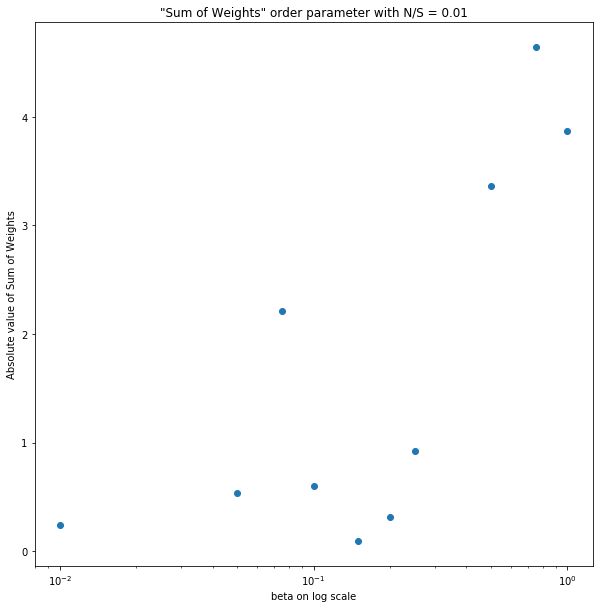

In [35]:
plt.figure(figsize=(10,10))
plt.plot((beta),(np.mean(abs(weights_sum4[:,:,50]),axis=0)),'o')
plt.xscale('log')
plt.xlabel('beta on log scale')
plt.ylabel('Absolute value of Sum of Weights')
plt.title('"Sum of Weights" order parameter with N/S = 0.01')